In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math 
from scipy.ndimage import gaussian_filter
# !apt-get install python3.9
import copy
from scipy.ndimage import maximum_filter
from tqdm import tqdm
import random

In [38]:
def minmax(image):
  image=(image - np.min(image))/np.ptp(image)
  return image

def FindCorners(image):
  originalImage=copy.deepcopy(image)
  image_g = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image_g = np.float32(image_g)
  probabilityScores = cv2.cornerHarris(image_g, 4, 1, 0.2) #5, 1, 0.2
  probabilityScores = cv2.dilate(probabilityScores, None)
  mask = probabilityScores > 0.005 * probabilityScores.max()
  image[mask]=[0, 0, 255]
  print("Harris Corners")
  plt.imshow(image)
  return originalImage ,probabilityScores

def ANMS(originalImage, probabilityScores, points):
  tempImg=copy.deepcopy(originalImage)
  localMaximas = maximum_filter(probabilityScores,size=20)
  newMask=(probabilityScores==localMaximas)   #create a mask whereever probability scores are equal to local maximas
  tempMask=(probabilityScores>0)              # to avoid the masks where all elements have 0 probability
  newMask=np.logical_and(newMask,tempMask)    # we want both conditions to be true, so using logical AND
  indexes=np.argwhere(newMask==True)
  # print(indexes)
  nStrong=indexes.shape[0]
  R = float('inf')* np.ones((nStrong,))
  ED = 0

  for i in tqdm(range(nStrong), total=nStrong):
    for j in range(nStrong):
      xi = indexes[i][0]
      yi = indexes[i][1]
      xj = indexes[j][0]
      yj = indexes[j][1]
      if probabilityScores[xj,yj] > probabilityScores[xi,yi]:
        ED = (xi-xj)**2 +(yi-yj)**2
      if ED < R[i]:
        R[i] = ED
  tempR = np.argsort(-R)
  bestPoints = indexes[tempR[:points]]


  print("Number of final points after ANMS:",bestPoints.shape)
  for x,y in bestPoints:
    x_i=y
    y_i=x
    cv2.circle(tempImg,(x_i, y_i),1,(0,255,0),-1)
  plt.imshow(tempImg)

  return bestPoints


def featExt(originalImage, bestPoints):
  grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)

  imagePad=np.pad(grayImage,(20,20),mode='edge')
  features = []
  flag = 50
  for x,y in bestPoints:
    x_int=y
    y_int=x
    small_patch=imagePad[x:x+40,y:y+40]
    gauss_patch=cv2.GaussianBlur(small_patch,(3,3),cv2.BORDER_DEFAULT)
    subsampled=gauss_patch[0::5,0::5]
    # cv2_imshow(subsampled)
    feature=np.reshape(subsampled,(64,1))
    feature=((feature-np.mean(feature))/(np.std(feature)))
    features.append(feature)
  features=np.array(features)
  # cv2_imshow(features[:,:,:10])
  return features

def featureMapping(features_1,features_2,threshold=0.9):
  print('Feature Mapping ...')
  matched_pairs=[]
  for i,feature_1 in enumerate(features_1):
    lowest_dist=float('inf')
    second_lowest_dist=float('inf')
    best_index=0
    for j, feature_2 in enumerate(features_2):
      distance=(feature_1-feature_2)**2
      distance=np.sum(distance)
      distance=np.sqrt(distance)
      if distance < lowest_dist:
        second_lowest_dist=lowest_dist    #updating lowest and second lowest distances at every iteration.
        lowest_dist=distance
        best_index=j
      elif distance < second_lowest_dist:
        second_lowest_dist=distance
    ratio=lowest_dist/second_lowest_dist
    if ratio<threshold:
      matched_pairs.append([i,best_index])
  print(f"Number of matching pairs = {len(matched_pairs)}")
  return matched_pairs

def visualize_pairs(image_1,image_2,top_points_1,top_points_2,matched_pairs,title='Mapping'):
  temp_img1=copy.deepcopy(image_1)
  temp_img2=copy.deepcopy(image_2)
  keypoints1=[]
  keypoints2=[]
  match_vector=[]
  ### Converting data into required data to visualize matches. Into KeyPoints and DMatch datatypes.
  for x,y in top_points_1:
    keypoints1.append(cv2.KeyPoint(int(y),int(x),3))	
  for x,y in top_points_2:
    keypoints2.append(cv2.KeyPoint(int(y),int(x),3))
  for li in matched_pairs:
    match_vector.append(cv2.DMatch(li[0],li[1],1))
  matchedImg=np.array([])
  matchedImg = cv2.drawMatches(temp_img1, keypoints1, temp_img2, keypoints2, match_vector,matchedImg)
  # cv2.imwrite(f'{title}.jpg',matchedImg)
  plt.imshow(matchedImg)
  return matchedImg



def doRANSAC(matched_pairs,top_points_1,top_points_2,iterations=1000,distance_threshold=100):
  print('Doing RANSAC')
  # count_epochs=0
  max_inliers=5
  good_match_flag=False
  inliers1=[]
  inliers2=[]
  matched_pairs_final=[]
  homography_matrix=np.array([])
  H_best=None
  if len(matched_pairs)<4:
    return matched_pairs,homography_matrix,good_match_flag

  for count_epochs in tqdm(range(iterations),total=iterations):
    temp_inlier_1=[]
    temp_inlier_2=[]
    temp_matching_pairs=[]
    random_indexes=random.sample(range(len(matched_pairs)),4)
    pts_1=[]
    pts_2=[]

    for i in range(4):
      pts_1.append(top_points_1[matched_pairs[random_indexes[i]][0]])
      pts_2.append(top_points_2[matched_pairs[random_indexes[i]][1]])
    
    pts_1=np.array(pts_1).astype('float32')
    pts_2=np.array(pts_2).astype('float32')
    H = cv2.getPerspectiveTransform(pts_1,pts_2)
    # print(H)

    for k in range(len(matched_pairs)):

      point_1=top_points_1[matched_pairs[k][0]]
      point_2=top_points_2[matched_pairs[k][1]]
      point_1_projected = np.append(point_1, [1], axis = 0)
      # print(f"1 = {point_1_projected}")
      point_1_projected = np.matrix.transpose(point_1_projected)
      # print(f"2 = {point_1_projected}")		
      point_1_projected = np.matmul(H,point_1_projected)
      # print(f"3 = {point_1_projected}")
      point_1_projected=np.delete(point_1_projected,2)
      # print(f"4 = {point_1_projected}")

      dist=(point_1_projected-point_2)**2
      dist=np.sum(dist)

      if dist < distance_threshold:
        temp_matching_pairs.append(matched_pairs[k])
        temp_inlier_1.append(top_points_1[matched_pairs[k][0]])
        temp_inlier_2.append(top_points_2[matched_pairs[k][1]])

    if len(temp_matching_pairs)>max_inliers:
      H_best=H
      matched_pairs_final=temp_matching_pairs
      inliers1=temp_inlier_1
      inliers2=temp_inlier_2
      break

  if len(matched_pairs_final)>4:
    good_match_flag=True

  print("Final matching pairs are:",len(matched_pairs_final))
  if (len(matched_pairs_final) != 0):
    inliers1=np.array(inliers1)
    inliers2=np.array(inliers2)
    print(f"inliers = {inliers1.shape} and {inliers2.shape}")

    homography_matrix,_ = cv2.findHomography(np.float32(inliers1),np.float32(inliers2))
    print(homography_matrix)
    return matched_pairs_final,homography_matrix,good_match_flag, inliers1, inliers2
  if (len(matched_pairs_final) == 0):
    print("No inliers found.") 
    return None, None, None, None, None  

def stitch(originalImage1, originalImage2, homography_matrix):
  
  h, w, z = originalImage1.shape
  p = np.array([[0, w, w, 0], [0, 0, h, h], [1, 1, 1, 1]])
  pp = np.dot(homography_matrix, p)

  yrow = pp[1] / pp[2]
  xrow = pp[0] / pp[2]
  ymin = min(yrow)
  # print(ymin)
  xmin = min(xrow)
  ymax = max(yrow)
  # print(ymax)
  xmax = max(xrow)

  new_mat = np.array([[1, 0, -1 * xmin], [0, 1, -1 * ymin], [0, 0, 1]])
  homography = np.dot(new_mat, homography_matrix)

  height = int(round(ymax - ymin))+ originalImage2.shape[0] 
  width = int(round(xmax - xmin))+ originalImage2.shape[1] 

  size = (height,width)
  print(f"size = {size}")

  warped = cv2.warpPerspective(src=originalImage1, M=homography, dsize=size)
  print(f"size of warped = {warped.shape}")
  plt.imshow(warped)

  offX = int(xmin)
  offY = int(ymin)
  oX = abs(offX)
  oY = abs(offY)
  print(f"oX = {oX} and oY = {oY}")
  # print(f"img2 size = {img2.shape[0]}")
  for x in range(oX,img2.shape[0]+oX):
      for y in range(oY,img2.shape[1]+oY):
          img2_y = y - oY
          img2_x = x - oX
          warped[x,y,:]=originalImage2[img2_x,img2_y,:] 

  img1 = warped
  pano = img1 
  print(warped.shape)
  plt.imshow(pano)
  return pano




Harris Corners


100%|████████████████████████████████| 6741/6741 [01:01<00:00, 110.32it/s]


Number of final points after ANMS: (500, 2)
Harris Corners


100%|████████████████████████████████| 6545/6545 [00:57<00:00, 113.01it/s]


Number of final points after ANMS: (500, 2)


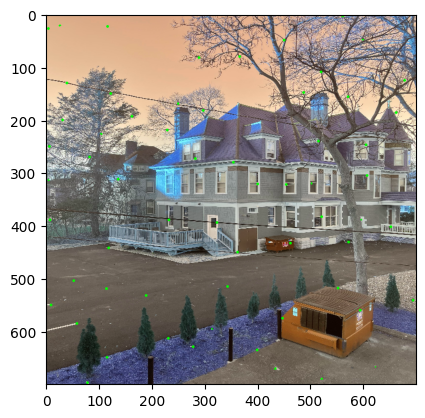

In [39]:
img1 = cv2.imread("Data/Train/image_one.jpg")
img1 = cv2.resize(img1, (700,700))
originalImage1, probabilityScores1 = FindCorners(img1)
bestPoints1 = ANMS(originalImage1, probabilityScores1, points=500)
features_1 = featExt(originalImage1, bestPoints1)

img2 = cv2.imread("Data/Train/image_two.jpg")
img2 = cv2.resize(img2, (700,700))
originalImage2, probabilityScores2 = FindCorners(img2)
bestPoints2 = ANMS(originalImage2, probabilityScores2, points=500)
features_2 = featExt(originalImage2, bestPoints2)

Feature Mapping ...
Number of matching pairs = 37
Doing RANSAC


  3%|█                                | 32/1000 [00:00<00:00, 1350.29it/s]

Final matching pairs are: 8
inliers = (8, 2) and (8, 2)
[[-6.70319784e+00  1.59816786e+01  2.03065150e+02]
 [-9.92424106e+00  2.29061039e+01  3.91369243e+02]
 [-2.19442693e-02  4.96089892e-02  1.00000000e+00]]
size = (774, 826)
size of warped = (826, 774, 3)
oX = 203 and oY = 391


IndexError: index 774 is out of bounds for axis 1 with size 774

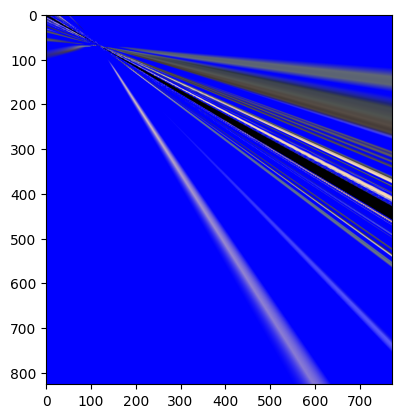

In [40]:
matched_pairs=featureMapping(features_1,features_2)
matchedImg=visualize_pairs(originalImage1,originalImage2,bestPoints1,bestPoints2,matched_pairs,title='beforeRansac')
final_matched_pairs,homography_matrix12,flag, inliers1, inliers2=doRANSAC(matched_pairs,bestPoints1,bestPoints2)
matchedImg_ransac=visualize_pairs(originalImage1,originalImage2,bestPoints1,bestPoints2,final_matched_pairs,title='afterRansac')

stitched12 = stitch(img1, img2, homography_matrix12)
Image12 = cv2.imwrite('Stitch12.jpg',stitched12) 

